In [51]:
import pandas as pd


import numpy as np
import seaborn as sns
import sys
import json
import ast
import os
from intreg.intreg import IntReg

import matplotlib.image as mpimg
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.stats import norm

%load_ext autoreload

%autoreload 2

sys.path.append("../")
from protocols import utils

import warnings
warnings.filterwarnings(
    "ignore",
    category=RuntimeWarning,
    message="invalid value encountered in scalar divide",
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
mutations = pd.read_csv('./data/MUTATIONS_BDQ.csv.gz').reset_index()

#read in the mutations tables, subsetted down to BDQ WHO-defined candidate genes
mutations = pd.read_csv('./data/MUTATIONS_BDQ.csv.gz').reset_index()
#GARC mutation naming
mutations["MUTATION"] = mutations.apply(
    lambda x: f"{x['GENE']}@{x['MINOR_MUTATION'] if x['IS_MINOR_ALLELE'] else x['MUTATION']}",
    axis=1,
)
#flag sysnonymous mutations
mutations["IS_SYNONYMOUS"] = mutations["MUTATION"].apply(
    lambda x: x.split("@")[-1][0] == x.split("@")[-1][-1]
)
#flag null calls
mutations["IS_NULL"] = mutations["MUTATION"].apply(
    lambda x: x.split("@")[-1][-1]  == 'Z'
)
mutations["FRS"] = mutations.apply(
    lambda x: 1 if not x["IS_MINOR_ALLELE"] else x["FRS"], axis=1
)

mutations = mutations[~mutations.GENE.isin(['mmpL5', 'mmpS5'])]

#read in table of genomes
genomes = pd.read_csv("./data/GENOMES.csv.gz").reset_index()

#read in cyrptic samples
phenotypes_cryptic = pd.read_csv("./data/DST_MEASUREMENTS_BDQ_CRYPTIC.csv.gz").reset_index()
phenotypes_cryptic_samples = set(phenotypes_cryptic.UNIQUEID)
#filter for high quality phenotypes from UKMYC5 and UKMYC6 plates
phenotypes_cryptic = phenotypes_cryptic[phenotypes_cryptic.METHOD_3.isin(['UKMYC5','UKMYC6'])]
phenotypes_cryptic = phenotypes_cryptic[phenotypes_cryptic.QUALITY=='HIGH']
phenotypes_cryptic = phenotypes_cryptic[phenotypes_cryptic.UNIQUEID.isin(genomes.UNIQUEID)]

assert phenotypes_cryptic.UNIQUEID.nunique() == len(phenotypes_cryptic.UNIQUEID), 'one or more samples have more than one DST measurement!'

#read in new nicd samples
phenotypes_nicd = pd.read_csv("./data/DST_MEASUREMENTS_BDQ_NICD.csv.gz").reset_index()
phenotypes_nicd_samples = set(phenotypes_nicd.UNIQUEID)
#filter for mgit samples
has_mgit = phenotypes_nicd[phenotypes_nicd.METHOD_CC=='WHO'].UNIQUEID
phenotypes_nicd = phenotypes_nicd[phenotypes_nicd.UNIQUEID.isin(has_mgit)]
#filter for samples with genomes
phenotypes_nicd = phenotypes_nicd[phenotypes_nicd.UNIQUEID.isin(genomes.UNIQUEID)]
# for samples with more than one DST result this will return the resistant one if they disagree and the MIC if they agree
phenotypes_nicd = phenotypes_nicd.groupby("UNIQUEID").apply(utils.filter_multiple_phenos)

#combine cryptic and nicd phenotype tables
assert len(phenotypes_nicd_samples.intersection(phenotypes_cryptic_samples)) == 0, "data sets are not mutually exclusive!"
phenotypes = pd.concat([phenotypes_cryptic, phenotypes_nicd]) 
assert phenotypes.UNIQUEID.nunique() == len(phenotypes.UNIQUEID), 'one or more samples have more than one DST measurement!'

#read in growth data of the cryptic plates
growth = pd.read_csv("./data/UKMYC_GROWTH_BDQ.csv.gz")

samples = pd.merge(phenotypes, genomes, how='inner', on=['UNIQUEID'])[["UNIQUEID", "DRUG", "SOURCE", "METHOD_3", "PHENOTYPE", "METHOD_MIC", "METHOD_2"]]

all = pd.merge(mutations, samples, how='right', on=['UNIQUEID'])
all.dropna(subset=['METHOD_MIC'], inplace=True)
all['GENE'].fillna('None', inplace=True)


/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_2432/1395067981.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  phenotypes_nicd = phenotypes_nicd.groupby("UNIQUEID").apply(utils.filter_multiple_phenos)
/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_2432/1395067981.py:60: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=Tru

In [53]:
synonymous_mgit = []
synonymous_plate = []
wt_mgit = []
wt_plate = []

for i in all.UNIQUEID.unique():
    df = all[all.UNIQUEID == i]
    if df.METHOD_2.iloc[0] == 'MGIT':
        if len(df) == 1 and df.IS_SYNONYMOUS.iloc[0] == True:
            synonymous_mgit.append(df.UNIQUEID.iloc[0])
        elif pd.isna(df.MUTATION.iloc[0]):  
            wt_mgit.append(df.UNIQUEID.iloc[0])
    else:
        if len(df) == 1 and df.IS_SYNONYMOUS.iloc[0] == True:
            synonymous_plate.append(df.UNIQUEID.iloc[0])
        elif pd.isna(df.MUTATION.iloc[0]):
            wt_plate.append(df.UNIQUEID.iloc[0])

mgit_wts = all[all.UNIQUEID.isin(synonymous_mgit+wt_mgit)]
plate_wts = all[all.UNIQUEID.isin(synonymous_plate+wt_plate)]

mgit_mutants = all[(all.METHOD_2=='MGIT')&(~all.UNIQUEID.isin(synonymous_mgit+wt_mgit))]
plate_mutants = all[(all.METHOD_2=='microdilution plate')&(~all.UNIQUEID.isin(synonymous_plate+wt_plate))]

In [54]:
mgit_wts

,index,UNIQUEID,GENE,MUTATION,REF,ALT,NUCLEOTIDE_NUMBER,NUCLEOTIDE_INDEX,GENE_POSITION,CODES_PROTEIN,...,MINOR_MUTATION,FRS,IS_SYNONYMOUS,IS_NULL,DRUG,SOURCE,METHOD_3,PHENOTYPE,METHOD_MIC,METHOD_2
11368,NaN,site.10.subj.BC01130569.lab.BC01130569.iso.1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,BDQ,NICD,MGIT960,R,2,MGIT
11370,NaN,site.10.subj.BC01202171.lab.BC01202171.iso.1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,BDQ,NICD,MGIT960,S,0.5,MGIT
11371,NaN,site.10.subj.BC01215382.lab.BC01215382.iso.1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,BDQ,NICD,MGIT960,S,0.5,MGIT
11372,NaN,site.10.subj.BC01232303.lab.BC01232303.iso.1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,BDQ,NICD,MGIT960,S,<=0.125,MGIT
11410,NaN,site.10.subj.BC02025022.lab.BC02025022.iso.1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,BDQ,NICD,MGIT960,R,4,MGIT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12719,NaN,site.10.subj.YA00118613.lab.YA00118613.iso.1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,BDQ,NICD,MGIT960,R,8,MGIT
12729,NaN,site.10.subj.YA00134347.lab.YA00134347.iso.1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,BDQ,NICD,MGIT960,S,0.5,MGIT
12735,NaN,site.10.subj.YA00138925.lab.YA00138925.iso.1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,BDQ,NICD,MGIT960,R,8,MGIT
12749,NaN,site.10.subj.YA00144829.lab.YA00144829.iso.1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,BDQ,NICD,MGIT960,S,1,MGIT


In [55]:
all[all.METHOD_2=='microdilution plate'].METHOD_MIC.value_counts()

METHOD_MIC
0.03       3772
0.06       3504
0.015      1587
<=0.015    1077
0.12        577
<=0.008     543
0.25        213
0.5          64
1.0          15
>1            7
>2            6
2.0           2
Name: count, dtype: int64

In [56]:
def plot_ecoff_distributions(y_low_log, y_high_log, mu_hat, sigma_hat, z_99):
    
    # WT MIC Intervals
    wt_intervals = [(low, high) for low, high in zip(y_low_log, y_high_log)]
    unique_wt_intervals = sorted(set(wt_intervals))
    wt_mic_counts = [wt_intervals.count(interval) for interval in unique_wt_intervals]
    wt_midpoints = [(low + high) / 2 for low, high in unique_wt_intervals]
    wt_widths = [high - low for low, high in unique_wt_intervals]
    total_wt = sum(wt_mic_counts)
    
    # WT Fitted Curve
    wt_x_values = np.linspace(min(y_low_log), max(y_high_log), 1000)
    wt_fitted_curve = (1 / (sigma_hat * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((wt_x_values - mu_hat) / sigma_hat) ** 2)
    wt_densities = [count / (total_wt * width) for count, width in zip(wt_mic_counts, wt_widths)]

    # Calculate the widest x-range
    x_min = min(y_low_log)
    x_max = max(y_high_log)

    # Create a single plot for WT
    fig, ax_wt = plt.subplots(1, 1, figsize=(6, 4))

    # Plot WT distribution
    ax_wt.bar(wt_midpoints, height=wt_densities, width=wt_widths,
              align='center', edgecolor='black', color='skyblue', alpha=0.9, label='WT MIC Intervals')
    ax_wt.plot(wt_x_values, wt_fitted_curve, color='darkBlue', linewidth=2, 
               label=f'WT Fitted Curve\n(mu={mu_hat:.2f}, sigma={sigma_hat:.2f})')
    if z_99 is not None:
        ax_wt.axvline(x=z_99, color='red', linestyle='--', linewidth=2, label='99th Percentile (log2(ECOFF))')
    ax_wt.set_xlabel('log2(MIC)', fontsize=12)
    ax_wt.set_ylabel('Density', fontsize=12)
    ax_wt.legend(frameon=False)
    ax_wt.spines['top'].set_visible(False)
    ax_wt.spines['right'].set_visible(False)
    ax_wt.set_title('WT MIC Distribution')
    ax_wt.set_xlim([x_min, x_max])

    plt.tight_layout()
    plt.show()


In [57]:
#Interval regression:
    #We are trying to estimate parameters of a normal distribution (mu, sigma) 
    #need a log likelihood function to measure how likely observed data is given these parameters
    #we maximise this likelihood to regress the interval censored MICs to find best parameters

def log_likelihood(params, y_low, y_high, left_bounds, right_bounds):

    mu, sigma = params

    log_L = 0

    # likelihood function for left-censored values
    left_censored = np.isin(np.round(y_low,0),  left_bounds)
    if np.any(left_censored):
        log_L += np.sum(norm.logcdf((y_high[left_censored] - mu) / sigma))

    # likelihood function for right-censored values
    right_censored = np.isin(np.round(y_high,0),  right_bounds)
    if np.any(right_censored):
        log_L += np.sum(np.log(1 - norm.cdf((y_low[right_censored] - mu) / sigma)))

    # likelihood function for intervals
    interval_censored = ~left_censored & ~right_censored & (y_low != y_high)
    if np.any(interval_censored):
        log_L += np.sum(
            np.log(
                norm.cdf((y_high[interval_censored] - mu) / sigma)
                - norm.cdf((y_low[interval_censored] - mu) / sigma)
            )
        )
    return -log_L


### OLD

In [32]:
#convert MICs into intervals (lower and upper bounds)
y_low, y_high= process_mic_data(plate_wts)
#log transform upper and lower bound arrays
y_low_log = np.log2(y_low, where=(y_low > 0))
y_high_log = np.log2(y_high, where=(y_high > 0))
#generate initial gaussian parameters
initial_params = [np.mean(y_high_log), np.std(y_high_log)]
#minimise the log likelihood function 
result = minimize(log_likelihood, initial_params, args=(y_low_log, y_high_log, [-9, -10], [3, 4]), method='L-BFGS-B')
#fitted distributions mean and std
mu_hat, sigma_hat = result.x
#99th percentile =  (log(ecoff))
z_99 = mu_hat + 2.3263 * sigma_hat
#calculate ecoff (absolute)
ecoff = np.exp2(z_99)

/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_79999/1492271357.py:46: RuntimeWarning: divide by zero encountered in log
  log_L += np.sum(np.log(1 - norm.cdf((y_low[right_censored] - mu) / sigma)))
/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_79999/1492271357.py:52: RuntimeWarning: divide by zero encountered in log
  np.log(
/Users/dylanadlard/miniforge3/envs/BDQ_catalogue_builder/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


In [33]:
print (result, '\n')
print (z_99)
print (ecoff)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 14477.231244026323
        x: [-5.607e+00  1.186e+00]
      nit: 3
      jac: [-8.983e+02  1.378e+03]
     nfev: 15
     njev: 5
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64> 

-2.848516052901767
0.13883891943191531


In [8]:
plot_ecoff_distributions(y_low_log, y_high_log, mu_hat, sigma_hat, z_99)

NameError: name 'y_low_log' is not defined

### NEW

In [58]:
def process_mic_data(df):
    y_low = []
    y_high = []

    dilution_factor = 2
    tail_dilution_factor = dilution_factor ** 3 #3 doubling dilutions (or 3 log2MICs) censored extension on either side

    for mic in df['METHOD_MIC']:
        if mic.startswith('<='):
            lower_bound = float(mic[2:])
            y_low.append(lower_bound / tail_dilution_factor)  # Adjust for left-censoring
            #y_low.append(1e-6)
            y_high.append(lower_bound)
        elif mic.startswith('>'):
            upper_bound = float(mic[1:])
            y_low.append(upper_bound)
            y_high.append(upper_bound * tail_dilution_factor)  # Adjust for right-censoring
            #y_high.append(np.inf)
        else:
            # For exact MIC values, the interval is MIC - 1 doubling dilution
            mic_value = float(mic)
            y_low.append(mic_value / dilution_factor)
            y_high.append(mic_value)
            
    #return lower and upper bound arrays rounded to 3 decimal places
    return np.array(y_low), np.array(y_high)

In [59]:
#convert MICs into intervals (lower and upper bounds)
y_low, y_high= process_mic_data(plate_wts)
#log transform upper and lower bound arrays
y_low_log = np.log2(y_low, where=(y_low > 0))
y_high_log = np.log2(y_high, where=(y_high > 0))
#generate initial gaussian parameters
initial_params = [np.mean(y_high_log), np.std(y_high_log)]
#minimise the log likelihood function 
model = IntReg(y_low_log, y_high_log).fit(method='L-BFGS-B', initial_params=initial_params)
#fitted distributions mean and std
mu_hat, log_sigma_hat = model.x
sigma_hat = np.exp(log_sigma_hat)
#99th percentile =  (log(ecoff))
z_99 = mu_hat + 2.3263 * sigma_hat
#calculate ecoff (absolute)
ecoff = np.exp2(z_99)

In [60]:
print (model, '\n')
print (z_99)
print (ecoff)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 14212.48888004395
        x: [-5.464e+00  3.555e-02]
      nit: 9
      jac: [ 1.114e+00 -2.440e+01]
     nfev: 147
     njev: 49
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64> 

-3.0534157298313946
0.12045650998183531


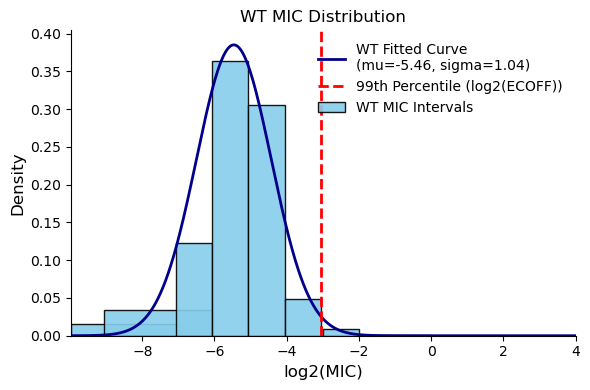

In [61]:
plot_ecoff_distributions(y_low_log, y_high_log, mu_hat, sigma_hat, z_99)

In [62]:
#convert MICs into intervals (lower and upper bounds)
y_low_mutant, y_high_mutant= process_mic_data(plate_mutants)
#log transform upper and lower bound arrays
y_low_mutant_log = np.log2(y_low_mutant, where=(y_low_mutant > 0))
y_high_mutant_log = np.log2(y_high_mutant, where=(y_high_mutant > 0))
#generate initial gaussian parameters
initial_params = [np.mean(y_high_mutant_log), np.std(y_high_mutant_log)]
#minimise the log likelihood function 
model = IntReg(y_low_mutant_log, y_high_mutant_log).fit(method='L-BFGS-B', initial_params=None)
#fitted distributions mean and std
mu_hat_mutant, log_sigma_hat_mutant = model.x
sigma_hat_mutant = np.exp(log_sigma_hat)
#99th percentile =  (log(ecoff))
z_99 = mu_hat + 2.3263 * sigma_hat
#calculate ecoff (absolute)
ecoff = np.exp2(z_99)

In [50]:
plot_ecoff_distributions(y_low_log, y_high_log, y_low_mutant_log, y_high_mutant_log, 
                           mu_hat, sigma_hat, mu_hat_mutant, sigma_hat_mutant, z_99)

TypeError: plot_ecoff_distributions() takes 5 positional arguments but 9 were given

In [11]:
#WT samples:

#convert MICs into intervals (lower and upper bounds)
y_low, y_high= process_mic_data(plate_wts)
#log transform upper and lower bound arrays
y_low_log = np.log2(y_low, where=(y_low > 0))
y_high_log = np.log2(y_high, where=(y_high > 0))
#generate initial gaussian parameters
initial_params = [np.mean(y_high_log), np.std(y_high_log)]
#minimise the log likelihood function 
result = minimize(log_likelihood, initial_params, args=(y_low_log, y_high_log, [-9, -10], [3, 4]), method='L-BFGS-B')
#fitted distributions mean and std
mu_hat, sigma_hat = result.x
#99th percentile =  (log(ecoff))
z_99 = mu_hat + 2.3263 * sigma_hat
#calculate ecoff (absolute)
ecoff = np.exp2(z_99)

/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_73189/1492271357.py:46: RuntimeWarning: divide by zero encountered in log
  log_L += np.sum(np.log(1 - norm.cdf((y_low[right_censored] - mu) / sigma)))
/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_73189/1492271357.py:52: RuntimeWarning: divide by zero encountered in log
  np.log(


In [12]:
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 14477.231244026323
        x: [-5.607e+00  1.186e+00]
      nit: 3
      jac: [-8.983e+02  1.378e+03]
     nfev: 15
     njev: 5
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [435]:
print ('log2(ECOFF):', z_99)
print ('PLATE ECOFF:', ecoff)

log2(ECOFF): -2.848516052901767
PLATE ECOFF: 0.13883891943191531


In [436]:
#convert MICs into intervals (lower and upper bounds)
y_low, y_high= process_mic_data(mgit_wts)
#log transform upper and lower bound arrays
y_low_log = np.log2(y_low, where=(y_low > 0))
y_high_log = np.log2(y_high, where=(y_high > 0))
#generate initial gaussian parameters
initial_params = [np.mean(y_high_log), np.std(y_high_log)]
#minimise the log likelihood function 
result = minimize(log_likelihood, initial_params, args=(y_low_log, y_high_log, [-6], [4, 6]), method='L-BFGS-B')
#fitted distributions mean and std
mu_hat, sigma_hat = result.x
#99th percentile =  (log(ecoff))
z_99 = mu_hat + 2.3263 * sigma_hat
#calculate ecoff (absolute)
ecoff = np.exp2(z_99)

In [437]:
print ('log2(ECOFF):', z_99)
print ('MGIT ECOFF:', ecoff)

log2(ECOFF): 2.22710600026035
MGIT ECOFF: 4.681938552991897


In [439]:
#Mutant samples:

#convert MICs into intervals (lower and upper bounds)
y_low_mutant, y_high_mutant= process_mic_data(mgit_mutants)
#log transform upper and lower bound arrays
y_low_mutant_log = np.log2(y_low_mutant, where=(y_low_mutant > 0))
y_high_mutant_log = np.log2(y_high_mutant, where=(y_high_mutant > 0))
#generate initial gaussian parameters
initial_params = [np.mean(y_high_mutant_log), np.std(y_high_mutant_log)]
#minimise the log likelihood function 
result_mutant = minimize(log_likelihood, initial_params, args=(y_low_mutant_log, y_high_mutant_log, [-6], [4, 6]), method='L-BFGS-B')
#fitted distributions mean and std
mu_hat_mutant, sigma_hat_mutant = result_mutant.x

In [64]:
def plot_ecoff_distributions(y_low_log, y_high_log, y_low_mutant_log, y_high_mutant_log, 
                           mu_hat, sigma_hat, mu_hat_mutant, sigma_hat_mutant, z_99):
    
    wt_intervals = [(low, high) for low, high in zip(y_low_log, y_high_log)]
    mutant_intervals = [(low, high) for low, high in zip(y_low_mutant_log, y_high_mutant_log)]

    unique_wt_intervals = sorted(set(wt_intervals))
    unique_mutant_intervals = sorted(set(mutant_intervals))

    wt_mic_counts = [wt_intervals.count(interval) for interval in unique_wt_intervals]
    mutant_mic_counts = [mutant_intervals.count(interval) for interval in unique_mutant_intervals]

    wt_midpoints = [(low + high) / 2 for low, high in unique_wt_intervals]
    wt_widths = [high - low for low, high in unique_wt_intervals]

    mutant_midpoints = [(low + high) / 2 for low, high in unique_mutant_intervals]
    mutant_widths = [high - low for low, high in unique_mutant_intervals]

    total_wt = sum(wt_mic_counts)
    total_mutant = sum(mutant_mic_counts)

    wt_x_values = np.linspace(min(y_low_log), max(y_high_log), 1000)
    mutant_x_values = np.linspace(min(y_low_mutant_log), max(y_high_mutant_log), 1000)

    wt_fitted_curve = (1 / (sigma_hat * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((wt_x_values - mu_hat) / sigma_hat) ** 2)
    mutant_fitted_curve = (1 / (sigma_hat_mutant * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((mutant_x_values - mu_hat_mutant) / sigma_hat_mutant) ** 2)

    wt_densities = [count / (total_wt * width) for count, width in zip(wt_mic_counts, wt_widths)]
    mutant_densities = [count / (total_mutant * width) for count, width in zip(mutant_mic_counts, mutant_widths)]

    # Calculate the widest x-range
    x_min = min(min(y_low_log), min(y_low_mutant_log))
    x_max = max(max(y_high_log), max(y_high_mutant_log))

    fig, (ax_wt, ax_mutant) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    ax_wt.bar(wt_midpoints, height=wt_densities, width=wt_widths,
              align='center', edgecolor='black', color='skyblue', alpha=0.9, label='WT MIC Intervals')
    ax_wt.plot(wt_x_values, wt_fitted_curve, color='darkBlue', linewidth=2, 
               label=f'WT Fitted Curve\n(mu={mu_hat:.2f}, sigma={sigma_hat:.2f})')
    ax_wt.axvline(x=z_99, color='red', linestyle='--', linewidth=2, label='99th Percentile (log2(ECOFF))')
    ax_wt.set_xlabel('log2(MIC)', fontsize=12)
    ax_wt.set_ylabel('Density', fontsize=12)
    ax_wt.legend(frameon=False)
    ax_wt.spines['top'].set_visible(False)
    ax_wt.spines['right'].set_visible(False)
    ax_wt.set_title('WT MIC Distribution')
    ax_wt.set_xlim([x_min, x_max])  # Apply the same x-limits to both plots

    ax_mutant.bar(mutant_midpoints, height=mutant_densities, width=mutant_widths,
                  align='center', edgecolor='black', color='lightgreen', alpha=0.9, label='Mutant MIC Intervals')
    ax_mutant.plot(mutant_x_values, mutant_fitted_curve, color='darkGreen', linewidth=2, 
                   label=f'Mutant Fitted Curve\n(mu={mu_hat_mutant:.2f}, sigma={sigma_hat_mutant:.2f})')
    ax_mutant.axvline(x=z_99, color='red', linestyle='--', linewidth=2, label='99th Percentile (log2(ECOFF))')
    ax_mutant.set_xlabel('log2(MIC)', fontsize=12)
    ax_mutant.legend(frameon=False)
    ax_mutant.spines['top'].set_visible(False)
    ax_mutant.spines['right'].set_visible(False)
    ax_mutant.set_title('Mutant MIC Distribution')
    ax_mutant.set_xlim([x_min, x_max])  # Apply the same x-limits to both plots

    plt.tight_layout()
    plt.show()

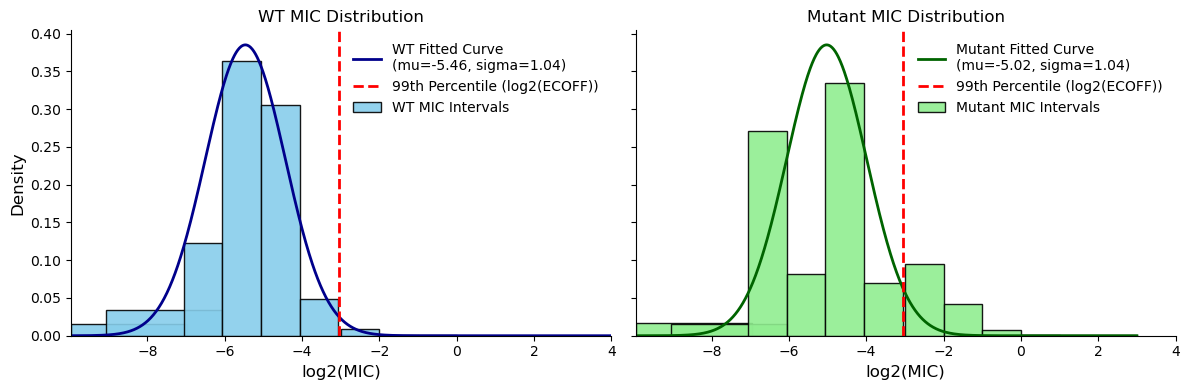

In [65]:
plot_ecoff_distributions(y_low_log, y_high_log, y_low_mutant_log, y_high_mutant_log, 
                           mu_hat, sigma_hat, mu_hat_mutant, sigma_hat_mutant, z_99)


Its interesting to note, very few mutant demonstrate elevated MICs on the plate - not resistant?

Mean of wts is higher than mutants - looks odd, but there are like 10000 mutant samples and < 10 WT, so...

Those wt samples on the far right are really annoying - wonder if i can justify getting rid of them? The bar is because we're plotting the higher bound of the interval, for the truncated bits which are not not on the plate. So don't be too misled by that bar the question is can we get rid of wt samples with v high MICs? Probs not

Okay - this all changes whether we include mmpL5-mmpS5 or not - drastically changes how many 'wt' samples we have. Ecluding mmpL5 mutations (ie these are now wts) shifts predicted distribution left by an entire doubling dilution.... Should perhaps follow this up for BDQ paper - ie, using a binary approach looks like mmpL5 doesnt matter, but from an MIC approach it seems to have an affect (should see if statistically significant).

## To think about:
- 99th percentile of genetically WT distribution is simple and seems to work, but there are other options:
    - Claudio mentioned taking the lower 99th percentile of the non-WT population (assuming he meant phenotypic) - because we care about the non-WTs and some drugs have overlapping distributions
    - but, could also explore:
    -   Bayesian mixed model of MICs as a mixture of WT and non-WT distributions and use bayesian inference to estimate the most probably cutff point. This could return intervals within with the cutoff is likely to fall (as oppose to single percentile point), accounting for uncertainty
    - Could also think about ROC curve analysis - calculate tradeoff between sensitivty and specifcity bu considering different cutoff points and calculating TPR and FPR

- Should validate on other drugs - see what we get and compare to ecoff paper to make sure we've replicated sufficiently

Something to think about - when using interval regression for MIC classifications, one could convert those MIC labels to ternary labels using some threshold (ecoff or perhaps calculated each time?). If this was done dynamically, those that are S could be removed to proffer additional solos - or perhaps, even added to the wt samples to recalculate the threshold? What would the benefit of this be? Probs just overcomplicated and would shift wt mean right, making it harder to classify S - a table of identical MICs with different ternay labels would look very odd. 



Also, remember although these are a tonne of samples - they are old plates ahdn thus for BDQ mostly S. The mgit samplesa re the really vaulable ones, but cant reclculate ecoff for that. Nor does it look like we can lower the ecoff for the plates.

So best to move on to interval ression. Can revist ecoff when binarising/ternarising MIC labels.

# OTHER DRUGS

### Prepare data for all drugs

In [71]:
phenos = pd.read_pickle('../cryptic-tables-v2.1.1/DST_MEASUREMENTS.pkl.gz').reset_index()
phenos = phenos[phenos.QUALITY=='HIGH']
genomes = pd.read_pickle('../cryptic-tables-v2.1.1/GENOMES.pkl.gz').reset_index()

In [51]:
drugs = {
    "INH": {"genes": ["inhA", "katG", "fabG1"], "seed": {"katG@R463L": "S"}},
    "RIF": {"genes": ["rpoA", "rpoB", "rpoC"], "seed": {}},
    "KAN": {"genes": ["rrs", "eis"], "seed": {}},
    "AMI": {"genes": ["rrs", "eis"], "seed": {}},
    "MXF": {"genes": ["gyrA", "gyrB"], "seed": {"gyrA@E21Q": "S"}},
    "EMB": {"genes": ["embB"], "seed": {}},
    "LEV": {
        "genes": ["gyrA", "gyrB"],
        "seed": {"gyrA@S95T": "S", "gyrA@E21Q": "S", "gyrA@G668D": "S"},
    },
    "LZD": {"genes": ["rplC", "rrl"], "seed": {}},
    # "STM": {"genes": ["rrs", "gid", "rpsL"], "seed": {}},
    "DLM": {"genes": ["ddn", "fbiA", "fbiC", "fbiB"], "seed": {}},
    "ETH": {"genes": ["inhA", "ethA"], "seed": {}},
}

dfs = {}

for drug, genes in drugs.items():
    print(drug)
    if not os.path.exists(
        f"./data/ignore/cryptic_drugs_v2.1.1/{drug.lower()}_mutations.csv"
    ):
        mutations = pd.read_pickle(
            "../cryptic-tables-v2.1.1/MUTATIONS.pkl.gz"
        ).reset_index()
        mutations = mutations[mutations.GENE.isin(genes["genes"])]
        mutations.to_csv(
            f"./data/ignore/cryptic_drugs_v2.1.1/{drug.lower()}_mutations.csv"
        )

    mutations = pd.read_csv(
        f"./data/ignore/cryptic_drugs_v2.1.1/{drug.lower()}_mutations.csv"
    )

    mutations["MUTATION"] = mutations.apply(
        lambda x: f"{x['GENE']}@{x['MINOR_MUTATION'] if x['IS_MINOR_ALLELE'] else x['MUTATION']}",
        axis=1,
    )
    mutations["IS_SYNONYMOUS"] = mutations["MUTATION"].apply(
        lambda x: x.split("@")[-1][0] == x.split("@")[-1][-1]
    )
    mutations["IS_NULL"] = mutations["MUTATION"].apply(
        lambda x: x.split("@")[-1][-1] == "Z"
    )
    mutations["FRS"] = mutations.apply(
        lambda x: 1 if not x["IS_MINOR_ALLELE"] else x["FRS"], axis=1
    )

    phenotypes = phenos[phenos.DRUG == drug]
    ukmyc5_phenos = (
        phenotypes[phenotypes.METHOD_3 == "UKMYC5"]
        .groupby("UNIQUEID", group_keys=False)
        .apply(utils.filter_multiple_phenos)
    )
    ukmyc6_phenos = (
        phenotypes[phenotypes.METHOD_3 == "UKMYC6"]
        .groupby("UNIQUEID", group_keys=False)
        .apply(utils.filter_multiple_phenos)
    )

    ukmyc5_samples = pd.merge(ukmyc5_phenos, genomes, how="inner", on=["UNIQUEID"])
    ukmyc6_samples = pd.merge(ukmyc6_phenos, genomes, how="inner", on=["UNIQUEID"])

    ukmyc5 = pd.merge(mutations, ukmyc5_samples, how="right", on=["UNIQUEID"])
    ukmyc6 = pd.merge(mutations, ukmyc6_samples, how="right", on=["UNIQUEID"])

    ukmyc5.dropna(subset=["METHOD_MIC"], inplace=True)
    ukmyc6.dropna(subset=["METHOD_MIC"], inplace=True)

    ukmyc5["GENE"].fillna("None", inplace=True)
    ukmyc6["GENE"].fillna("None", inplace=True)

    ukmyc5_wts = ukmyc5[
        ukmyc5.UNIQUEID.isin(
            i
            for i in ukmyc5.UNIQUEID.unique()
            if (
                len(ukmyc5[ukmyc5.UNIQUEID == i]) == 1
                and ukmyc5.loc[ukmyc5.UNIQUEID == i, "IS_SYNONYMOUS"].iloc[0]
            )
            or pd.isna(ukmyc5.loc[ukmyc5.UNIQUEID == i, "MUTATION"].iloc[0])
        )
    ]

    ukmyc6_wts = ukmyc6[
        ukmyc6.UNIQUEID.isin(
            i
            for i in ukmyc6.UNIQUEID.unique()
            if (
                len(ukmyc6[ukmyc6.UNIQUEID == i]) == 1
                and ukmyc6.loc[ukmyc6.UNIQUEID == i, "IS_SYNONYMOUS"].iloc[0]
            )
            or pd.isna(ukmyc6.loc[ukmyc6.UNIQUEID == i, "MUTATION"].iloc[0])
        )
    ]

    ukmyc5_mutants = ukmyc5[~ukmyc5.UNIQUEID.isin(ukmyc5_wts.UNIQUEID)]
    ukmyc6_mutants = ukmyc6[~ukmyc6.UNIQUEID.isin(ukmyc6_wts.UNIQUEID)]

    dfs[drug] = {
        "UKMYC5": {"wt": ukmyc5_wts, "mutant": ukmyc5_mutants},
        "UKMYC6": {"wt": ukmyc6_wts, "mutant": ukmyc6_mutants},
    }

INH
RIF
KAN
AMI
MXF
EMB
LEV
LZD
DLM
ETH


### Rifampicin

In [444]:
ukmyc5_wts = dfs['RIF']['UKMYC5']['wt']
ukmyc6_wts = dfs['RIF']['UKMYC6']['wt']

In [445]:
y_low, y_high= process_mic_data(ukmyc6_wts)
y_low_log = np.log2(y_low, where=(y_low > 0))
y_high_log = np.log2(y_high, where=(y_high > 0))
initial_params = [np.mean(y_high_log), np.std(y_high_log)]
bounds = [(-9, 7), (0.001, 3)] 
result = minimize(log_likelihood, initial_params, args=(y_low_log, y_high_log, [-9], [7]), method='L-BFGS-B', bounds=bounds)
mu_hat, sigma_hat = result.x

z_99 = mu_hat + 2.3263 * sigma_hat
ecoff = np.exp2(z_99)

In [446]:
print ('log2(ECOFF):', z_99)
print ('ECOFF:', ecoff)

log2(ECOFF): -0.9357764874899526
ECOFF: 0.5227610336623956


In [447]:
ukmyc5_mutants = dfs['RIF']['UKMYC5']['mutant']
ukmyc6_mutants = dfs['RIF']['UKMYC6']['mutant']

y_low_mutant, y_high_mutant= process_mic_data(ukmyc6_mutants)
y_low_mutant_log = np.log2(y_low_mutant, where=(y_low_mutant > 0))
y_high_mutant_log = np.log2(y_high_mutant, where=(y_high_mutant > 0))
initial_params = [np.mean(y_high_mutant_log), np.std(y_high_mutant_log)]
bounds = [(-9, 7), (0.001, 3)] 
result_mutant = minimize(log_likelihood, initial_params, args=(y_low_mutant_log, y_high_mutant_log, [-9], [7]), method='L-BFGS-B', bounds=bounds)
mu_hat_mutant, sigma_hat_mutant = result_mutant.x


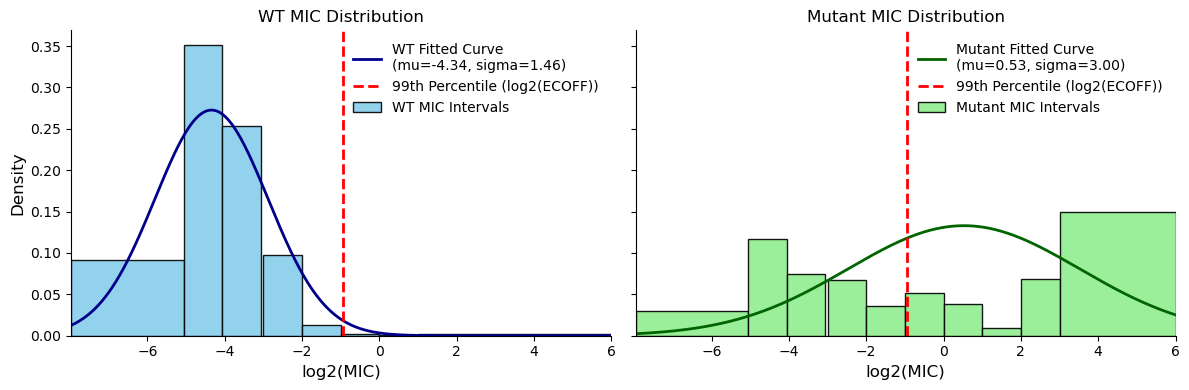

In [448]:
plot_ecoff_distributions(y_low_log, y_high_log, y_low_mutant_log, y_high_mutant_log, 
                           mu_hat, sigma_hat, mu_hat_mutant, sigma_hat_mutant, z_99)

### Isoniazid

In [449]:
ukmyc5_wts = dfs['INH']['UKMYC5']['wt']
ukmyc6_wts = dfs['INH']['UKMYC6']['wt']

In [450]:
y_low, y_high= process_mic_data(ukmyc5_wts)
y_low_log = np.log2(y_low, where=(y_low > 0))
y_high_log = np.log2(y_high, where=(y_high > 0))
initial_params = [np.mean(y_high_log), np.std(y_high_log)]
bounds = [(-8, 4), (0.001, 3)] 
result = minimize(log_likelihood, initial_params, args=(y_low_log, y_high_log, [-8], [4]), method='L-BFGS-B', bounds=bounds)
mu_hat, sigma_hat = result.x

z_99 = mu_hat + 2.3263 * sigma_hat
ecoff = np.exp2(z_99)

In [451]:
print ('log2(ECOFF):', z_99)
print ('ECOFF:', ecoff)

log2(ECOFF): -1.6485995797826907
ECOFF: 0.3189496101462148


In [452]:
ukmyc5_mutants = dfs['INH']['UKMYC5']['mutant']
ukmyc6_mutants = dfs['INH']['UKMYC6']['mutant']

y_low_mutant, y_high_mutant= process_mic_data(ukmyc5_mutants)
y_low_mutant_log = np.log2(y_low_mutant, where=(y_low_mutant > 0))
y_high_mutant_log = np.log2(y_high_mutant, where=(y_high_mutant > 0))
initial_params = [np.mean(y_high_mutant_log), np.std(y_high_mutant_log)]
bounds = [(-8, 4), (0.001, 3)] 
result_mutant = minimize(log_likelihood, initial_params, args=(y_low_mutant_log, y_high_mutant_log, [-8], [4]), method='L-BFGS-B', bounds=bounds)
mu_hat_mutant, sigma_hat_mutant = result_mutant.x


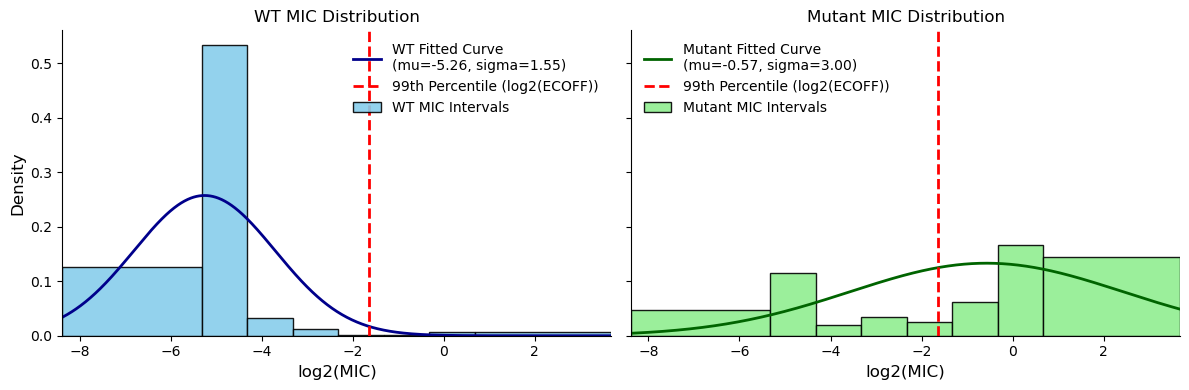

In [454]:
plot_ecoff_distributions(y_low_log, y_high_log, y_low_mutant_log, y_high_mutant_log, 
                           mu_hat, sigma_hat, mu_hat_mutant, sigma_hat_mutant, z_99)

### Ethambutol

In [455]:
ukmyc5_wts = dfs['EMB']['UKMYC5']['wt']
ukmyc6_wts = dfs['EMB']['UKMYC6']['wt']

In [456]:
y_low, y_high= process_mic_data(ukmyc5_wts)
y_low_log = np.log2(y_low, where=(y_low > 0))
y_high_log = np.log2(y_high, where=(y_high > 0))
initial_params = [np.mean(y_high_log), np.std(y_high_log)]
bounds = [(-7, 6), (0.001, 3)] 
result = minimize(log_likelihood, initial_params, args=(y_low_log, y_high_log, [-7], [6]), method='L-BFGS-B', bounds=bounds)
mu_hat, sigma_hat = result.x

z_99 = mu_hat + 2.3263 * sigma_hat
ecoff = np.exp2(z_99)

In [457]:
print ('log2(ECOFF):', z_99)
print ('ECOFF:', ecoff)

log2(ECOFF): 1.878390029843619
ECOFF: 3.6766453736100857


In [458]:
ukmyc5_mutants = dfs['EMB']['UKMYC5']['mutant']
ukmyc6_mutants = dfs['EMB']['UKMYC6']['mutant']

y_low_mutant, y_high_mutant= process_mic_data(ukmyc5_mutants)
y_low_mutant_log = np.log2(y_low_mutant, where=(y_low_mutant > 0))
y_high_mutant_log = np.log2(y_high_mutant, where=(y_high_mutant > 0))
initial_params = [np.mean(y_high_mutant_log), np.std(y_high_mutant_log)]
bounds = [(-7, 6), (0.001, 3)] 
result_mutant = minimize(log_likelihood, initial_params, args=(y_low_mutant_log, y_high_mutant_log, [-7], [6]), method='L-BFGS-B', bounds=bounds)
mu_hat_mutant, sigma_hat_mutant = result_mutant.x


/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_46478/1492271357.py:46: RuntimeWarning: divide by zero encountered in log
  log_L += np.sum(np.log(1 - norm.cdf((y_low[right_censored] - mu) / sigma)))
/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_46478/1492271357.py:52: RuntimeWarning: divide by zero encountered in log
  np.log(
/Users/dylanadlard/miniforge3/envs/BDQ_catalogue_builder/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


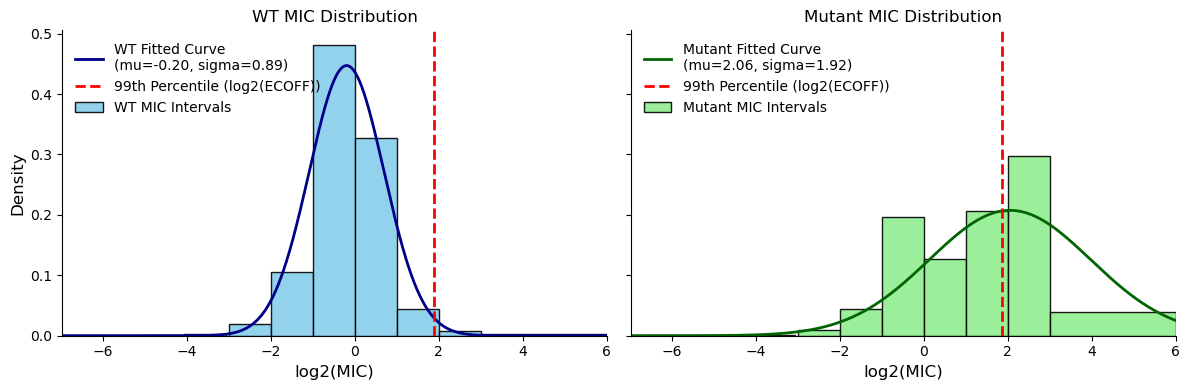

In [459]:
plot_ecoff_distributions(y_low_log, y_high_log, y_low_mutant_log, y_high_mutant_log, 
                           mu_hat, sigma_hat, mu_hat_mutant, sigma_hat_mutant, z_99)

### Kanamycin

In [460]:
ukmyc5_wts = dfs['KAN']['UKMYC5']['wt']
ukmyc6_wts = dfs['KAN']['UKMYC6']['wt']

In [461]:
y_low, y_high= process_mic_data(ukmyc5_wts)
y_low_log = np.log2(y_low, where=(y_low > 0))
y_high_log = np.log2(y_high, where=(y_high > 0))
initial_params = [np.mean(y_high_log), np.std(y_high_log)]
bounds = [(-3, 7), (0.001, 3)] 
result = minimize(log_likelihood, initial_params, args=(y_low_log, y_high_log, [-3], [7]), method='L-BFGS-B', bounds=bounds)
mu_hat, sigma_hat = result.x

z_99 = mu_hat + 2.3263 * sigma_hat
ecoff = np.exp2(z_99)

/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_46478/1492271357.py:46: RuntimeWarning: divide by zero encountered in log
  log_L += np.sum(np.log(1 - norm.cdf((y_low[right_censored] - mu) / sigma)))
/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_46478/1492271357.py:52: RuntimeWarning: divide by zero encountered in log
  np.log(


In [462]:
print ('log2(ECOFF):', z_99)
print ('ECOFF:', ecoff)

log2(ECOFF): 2.589870397897416
ECOFF: 6.020446128615093


In [463]:
ukmyc5_mutants = dfs['KAN']['UKMYC5']['mutant']
ukmyc6_mutants = dfs['KAN']['UKMYC6']['mutant']

y_low_mutant, y_high_mutant= process_mic_data(ukmyc5_mutants)
y_low_mutant_log = np.log2(y_low_mutant, where=(y_low_mutant > 0))
y_high_mutant_log = np.log2(y_high_mutant, where=(y_high_mutant > 0))
initial_params = [np.mean(y_high_mutant_log), np.std(y_high_mutant_log)]
bounds = [(-3, 7), (0.001, 3)] 
result_mutant = minimize(log_likelihood, initial_params, args=(y_low_mutant_log, y_high_mutant_log, [-3], [7]), method='L-BFGS-B', bounds=bounds)
mu_hat_mutant, sigma_hat_mutant = result_mutant.x


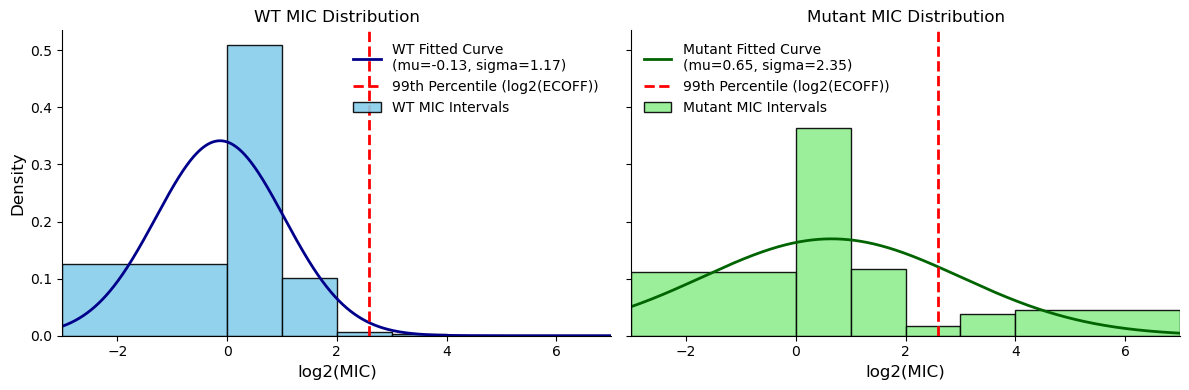

In [464]:
plot_ecoff_distributions(y_low_log, y_high_log, y_low_mutant_log, y_high_mutant_log, 
                           mu_hat, sigma_hat, mu_hat_mutant, sigma_hat_mutant, z_99)

### Moxifloxacin

In [477]:
ukmyc5_wts = dfs["MXF"]['UKMYC5']['wt']
ukmyc6_wts = dfs["MXF"]['UKMYC6']['wt']

In [482]:
y_low, y_high= process_mic_data(ukmyc6_wts)
y_low_log = np.log2(y_low, where=(y_low > 0))
y_high_log = np.log2(y_high, where=(y_high > 0))
initial_params = [np.mean(y_high_log), np.std(y_high_log)]
bounds = [(-3, 7), (0.001, 3)] 
result = minimize(log_likelihood, initial_params, args=(y_low_log, y_high_log, [-4], [7]), method='L-BFGS-B', bounds=bounds)
mu_hat, sigma_hat = result.x

z_99 = mu_hat + 2.3263 * sigma_hat
ecoff = np.exp2(z_99)

In [483]:
print ('log2(ECOFF):', z_99)
print ('ECOFF:', ecoff)

log2(ECOFF): 0.26753729230919765
ECOFF: 1.2037512467589047


In [484]:
ukmyc5_mutants = dfs['KAN']['UKMYC5']['mutant']
ukmyc6_mutants = dfs['KAN']['UKMYC6']['mutant']

y_low_mutant, y_high_mutant= process_mic_data(ukmyc6_mutants)
y_low_mutant_log = np.log2(y_low_mutant, where=(y_low_mutant > 0))
y_high_mutant_log = np.log2(y_high_mutant, where=(y_high_mutant > 0))
initial_params = [np.mean(y_high_mutant_log), np.std(y_high_mutant_log)]
bounds = [(-3, 7), (0.001, 3)] 
result_mutant = minimize(log_likelihood, initial_params, args=(y_low_mutant_log, y_high_mutant_log, [-4], [7]), method='L-BFGS-B', bounds=bounds)
mu_hat_mutant, sigma_hat_mutant = result_mutant.x


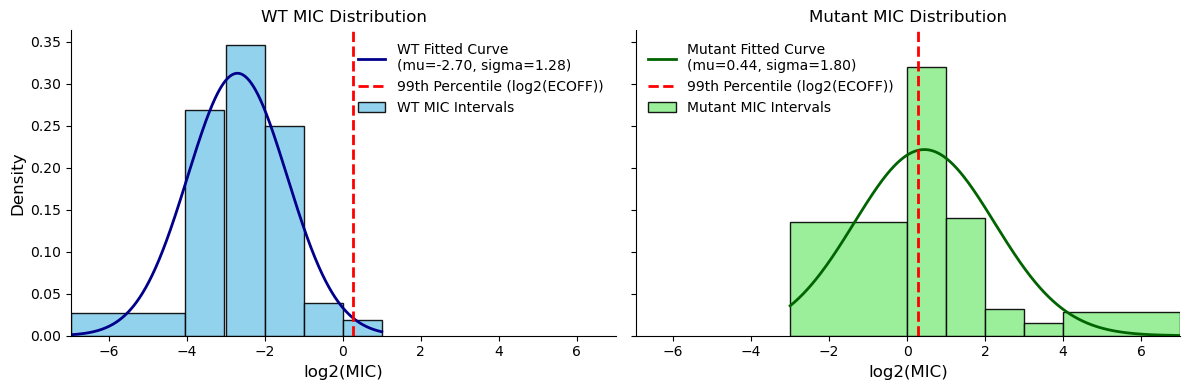

In [485]:
plot_ecoff_distributions(y_low_log, y_high_log, y_low_mutant_log, y_high_mutant_log, 
                           mu_hat, sigma_hat, mu_hat_mutant, sigma_hat_mutant, z_99)